In [1]:
using HDF5, PyPlot, Glob, CSV, DataFrames, Dates, Distributions, GLM, StatsBase, MAT, NaNStatistics

In [2]:
drv = "/mnt/a82d7171-92f9-48ad-9ba4-aea036c8fec8/data_storage/collabs/maya/oddball/"
outpath = drv*"output/"
motion_file = drv*"motion/motion_regression_1s_ISI.mat"
file_list = glob("*mat",drv)
fps = 4
colors=[[241, 106, 5],[82, 121, 111],[165, 0, 43],[79, 53, 155],[55,151,113],[191,124,25],[54,118,152]]./255

nsa = .002
ymn,ymx=200,1300
xmn,xmx=0,600

fs = 16

16

In [3]:
#1 ISI 
pnum = 3
snum = 7
isi = 1*fps

4

In [4]:
pipeline_output = h5open(file_list[pnum],"r")
keys(pipeline_output)

6-element Vector{String}:
 "#refs#"
 "DF"
 "ROI_centroids"
 "fish_ncells"
 "fish_numbers"
 "idx_fish"

In [5]:
centroids = pipeline_output["ROI_centroids"][]
idx_fish = pipeline_output["idx_fish"][]
file = matopen(file_list[snum],"r")
motion = matopen(motion_file,"r")
motion_reg = read(motion,"motion_regressor")
motion_corr = read(motion,"motion_correct")
keys(file)

KeySet for a Dict{String, Int64} with 4 entries. Keys:
  "framerate"
  "stimtimes"
  "stim_seq"
  "stim_freqs"

In [6]:
framerate = read(file,"framerate")
stimtimes = read(file,"stimtimes")
stimtimes = Int.(stimtimes)
stim_seq = vec(read(file,"stim_seq"))
stim_freqs = vec(read(file,"stim_freqs"))

5-element Vector{Float64}:
  531.0
 1189.0
  355.0
  794.0
 1778.0

In [7]:
DF = pipeline_output["DF"][]
IJulia.clear_output()

0

In [8]:
n_frames = length(DF[1,:])
total_rois = length(DF[:,1])
spike=[0,1.69644104899772,5.13796058542217,8.27886020152244,10.3756715204800,11.8173714529814,12.2425184714093,10.8571417354877,8.80831829681196,6.91339112244670,5.46959264663869,4.30868766622567,3.42533619066766,2.75378443486879,2.18017250852183,1.72816235135824,1.32732537295463,1.00684435500268,0.730210038304555,0.530242444093118,0.362253250339685,0.227668255288566,0.0869242416152502,0.000718266708050853,-0.0828334873368325]';
spike = vec(spike./maximum(spike))
IJulia.clear_output()

0

### Detect block edges and stimulus times

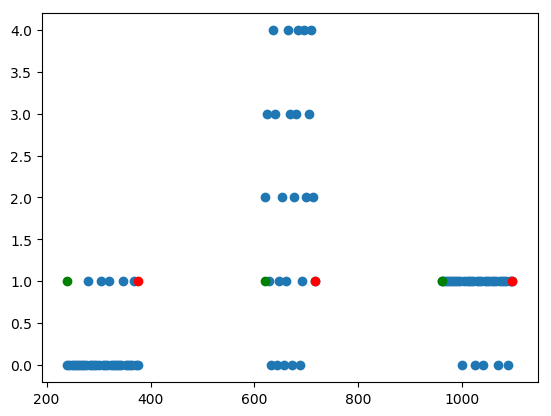

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/stednitz/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


10-element Vector{Int64}:
  272
  288
  328
  352
  376
  984
  992
 1008
 1072
 1080

In [9]:
scatter(stimtimes,stim_seq)

block_edges = Array{Int64}(undef,3,2)
b_ctr = 1
block_edges[1,1] = stimtimes[1]
block_edges[3,2] = stimtimes[end]
flag = 0
for s = 2:length(stimtimes)-1
    isi_now = stimtimes[s+1]-stimtimes[s]
    if isi_now > isi
        block_edges[b_ctr,2] = stimtimes[s]
        b_ctr+=1
        flag = 1
    end
    if flag == 1 && isi_now == isi
        block_edges[b_ctr,1] = stimtimes[s]
        flag = 0
    end
end

for b = 1:3
    scatter(block_edges[b,1],1,color="green")
    scatter(block_edges[b,2],1,color="red")
end

oddball_times = []
oddball_1st = []
oddball_2nd = []

for i = 1:35
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(oddball_times,stimtimes[i])
        append!(oddball_1st,stimtimes[i])
    end
end

for i = length(stimtimes)-35:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 0
        append!(oddball_times,stimtimes[i])
        append!(oddball_2nd,stimtimes[i])

    end
end

f1_times = []
f2_times = []
for i = 1:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(f1_times,stimtimes[i])
    end
end

ms_f1_times = []
ms_f2_times = []
ms_f3_times = []
ms_f4_times = []
ms_f5_times = []

for i = findall((stimtimes .>= block_edges[2,1]) .&& (stimtimes .<= block_edges[2,2]))
    curr_stim = stim_seq[i[2]]
    if curr_stim == 1
        append!(ms_f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(ms_f1_times,stimtimes[i])
    elseif curr_stim == 2
        append!(ms_f3_times,stimtimes[i])
    elseif curr_stim == 3
        append!(ms_f4_times,stimtimes[i])
    elseif curr_stim == 4
        append!(ms_f5_times,stimtimes[i])
    end
end

rng1 = Int(block_edges[1,1]):isi*2:Int(block_edges[1,2])
rng2 = Int(block_edges[3,1]):isi*2:Int(block_edges[3,2])

randtimes = vcat(sort(sample(rng1,5,replace=false)),sort(sample(rng2,5,replace=false)))

r1 = collect(rng1)
rn2 = collect(rng2)
filter!(r1->r1∉oddball_1st,r1)
filter!(rn2->rn2∉oddball_2nd,rn2)

offset_1 = sort(sample(r1, 5, replace=false))
offset_2 = sort(sample(rn2,5,replace=false))
offset_all = vcat(offset_1,offset_2)

### Compute regressors

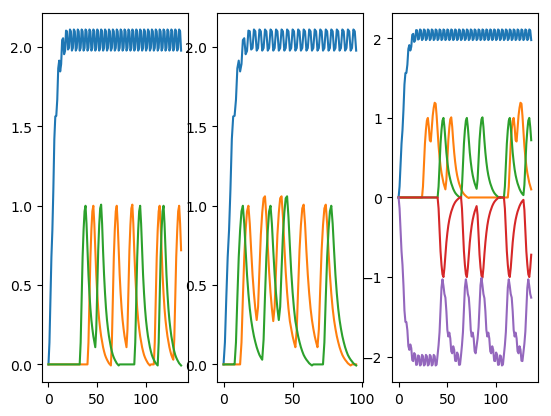

10-element Vector{String}:
 "auditory"
 "oddball"
 "oddball_offset"
 "random"
 "freq1"
 "freq2"
 "ob_1st"
 "ob_2nd"
 "ob_1st_offset"
 "ob_2nd_offset"

In [10]:
function compute_calcium(times)
    reg = zeros((n_frames))
    for stim in times
        nd = stim + length(spike)
        off = 0
        if length(reg) < stim+length(spike) 
            off = nd - length(reg)
            nd = length(reg)
        end
        reg[stim:nd-1] .+= spike[1:end-off]
    end
    return reg
end

auditory_reg = compute_calcium(stimtimes)
oddball_reg = compute_calcium(oddball_times)
oddball_offset_reg = compute_calcium(offset_all)
random_reg = compute_calcium(randtimes)

f1_reg = compute_calcium(f1_times)
f2_reg = compute_calcium(f2_times)

ms_f1_reg = compute_calcium(ms_f1_times)
ms_f2_reg = compute_calcium(ms_f2_times)

ob1_reg = compute_calcium(oddball_1st)
ob2_reg = compute_calcium(oddball_2nd)

ob1_offset_reg = compute_calcium(offset_1)
ob2_offset_reg = compute_calcium(offset_2)

subplot(131)
rng = block_edges[1,1]:block_edges[1,2]
plot(auditory_reg[rng])
plot(oddball_reg[rng])
plot(oddball_offset_reg[rng])

subplot(132)
rng = block_edges[2,1]:block_edges[2,2]
plot(auditory_reg[rng])
plot(f1_reg[rng])
plot(f2_reg[rng])

subplot(133)
rng = block_edges[3,1]:block_edges[3,2]
plot(auditory_reg[rng])
plot(oddball_offset_reg[rng])
plot(oddball_reg[rng])
plot(.-f1_reg[rng])
plot(.-f2_reg[rng])

exp_regs = [auditory_reg,oddball_reg,oddball_offset_reg,random_reg,f1_reg,f2_reg,ob1_reg,ob2_reg,ob1_offset_reg,ob2_offset_reg]#,motion_reg]
reg_titles = ["auditory","oddball","oddball_offset","random","freq1","freq2","ob_1st","ob_2nd","ob_1st_offset","ob_2nd_offset"]#,"motion"]

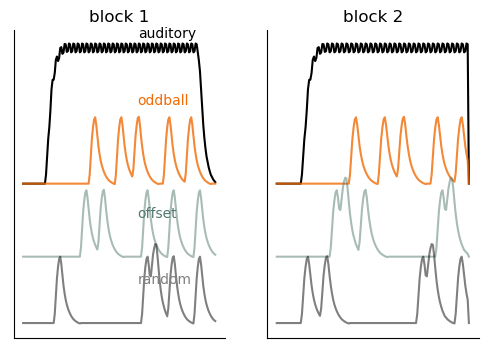

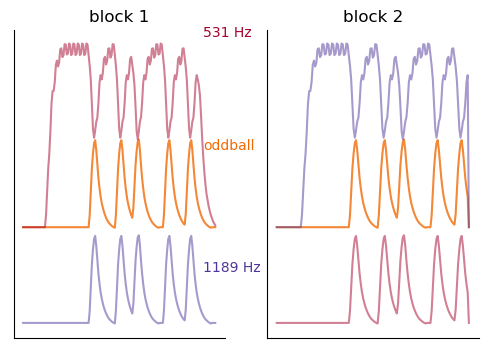

Any[]

In [11]:
figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 105
text(xpos,2.2,"auditory",color="black")
text(xpos,1.2,"oddball",color=colors[1])
text(xpos,-0.5,"offset",color=colors[2])
text(xpos,-1.5,"random",color="gray")

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
#plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f1_reg[rng],color=colors[3],alpha=0.5)
plot(f2_reg[rng].-1.1,color=colors[4],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 165
text(xpos,2.2,"531 Hz",color=colors[3])
text(xpos,0.9,"oddball",color=colors[1])
text(xpos,-0.5,"1189 Hz",color=colors[4])

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f2_reg[rng],color=colors[4],alpha=0.5)
plot(f1_reg[rng].-1.1,color=colors[3],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

In [12]:
exp_regs = [auditory_reg,oddball_reg,oddball_offset_reg,random_reg,f1_reg,f2_reg,ob1_reg,ob2_reg,ob1_offset_reg,ob2_offset_reg]

10-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.0995526962383515, 1.978030190476769, 1.9943201006071474, 2.111279517549821, 2.0995526962383515, 1.978030190476769, 1.9943201006071474, 2.111279517549821, 2.0995526962383515, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.6762969962076263, 0.8407451503692365, 0.9652729118260452, 1.0, 0.8868389098895824, 0.71948580820054, 0.5647033442172837, 0.446770218024352, 0.35194455097519445, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.39525610041916104, 0.3093799245516953, 0.24353262746714446, 0.1851822200988767, 0.14121935957081472, 0.10165325774464913, 0.08224160391132143, 0.05964541037939694, 0.043311549443966584, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.6762383263587934, 0.8475111999798847, 0.9652729118260452, 1.0, 0.8868389098895824, 0.71948580820054, 0.5647033442172837, 0.446770218024352, 0.35194455097519445, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

### Read in the existing regressed data

In [13]:
short_id = file_list[pnum][length(drv)+17:end-4]
outfile = outpath*short_id*".h5"

of = h5open(outfile,"r")
coeffs = Array{Float32}(undef,length(exp_regs),total_rois); fill!(coeffs,NaN)
r2s = Array{Float32}(undef,length(exp_regs),total_rois); fill!(r2s,NaN)
pvals = Array{Float32}(undef,length(exp_regs),total_rois); fill!(pvals,NaN)
sig_rois = Array{Int64}[]
nonsig_rois = Array{Int64}[]

for r=1:length(exp_regs)
    exp_regs[r] = of[reg_titles[r]]["reg"][]
    r2s[r,:] .= of[reg_titles[r]]["r2"][]
    coeffs[r,:] .= of[reg_titles[r]]["coef"][]
    pvals[r,:] .= of[reg_titles[r]]["pval"][]
end
close(of)

### Detect significant ROIs (p < .001/total ROIs && R^2 > 99th percentile)

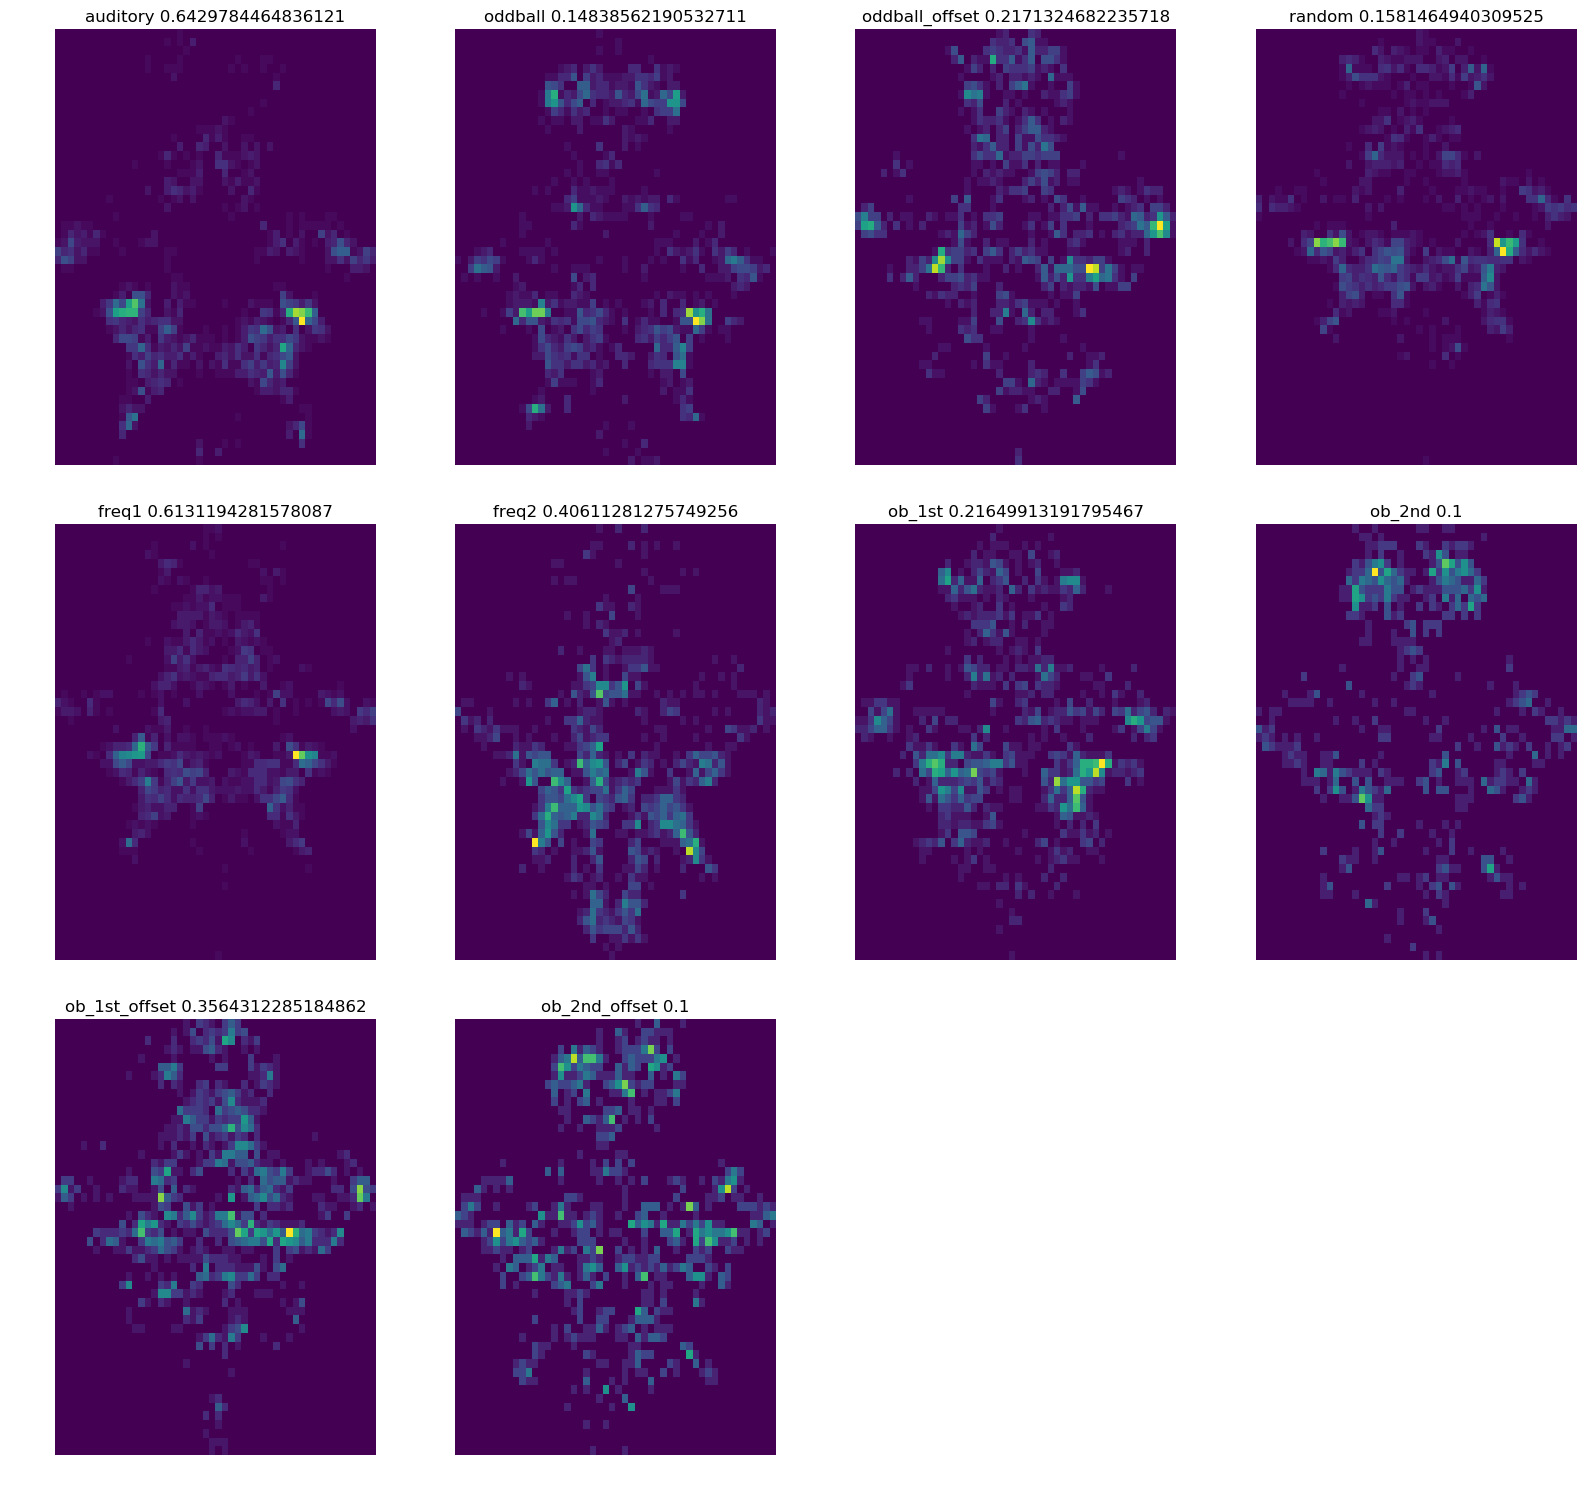

In [15]:
sig_rois = Array{Int64}[]
nonsig_rois = Array{Int64}[]

rows,cols=3,4
figure(figsize=(cols*4,rows*5)); 

alpha_cutoff = 0.001/total_rois
minimum_r2 = 0.1
perc_cutoff = 99
for r=1:length(exp_regs)
    pvals_clean = pvals[r,:]
    sig_roi_pval = findall(pvals_clean .< alpha_cutoff);
    
    r2s_clean = replace(r2s[r,:],NaN=>0)
    perc_99 = percentile(r2s_clean,perc_cutoff)
    if perc_99 < minimum_r2 perc_99 = minimum_r2 end
    
    sig_roi_r2 = findall(r2s_clean .> perc_99);
    
    sig_roi = intersect(sig_roi_pval,sig_roi_r2)
    nonsig_roi = collect(1:total_rois)
    deleteat!(nonsig_roi,sig_roi[1])

    push!(sig_rois,sig_roi)
    push!(nonsig_rois,nonsig_roi)
    subplot(rows,cols,r)
    title(reg_titles[r]*" $perc_99")
    plt.hist2d(centroids[sig_roi,2],centroids[sig_roi,1],bins=50); axis("off");
end

tight_layout()

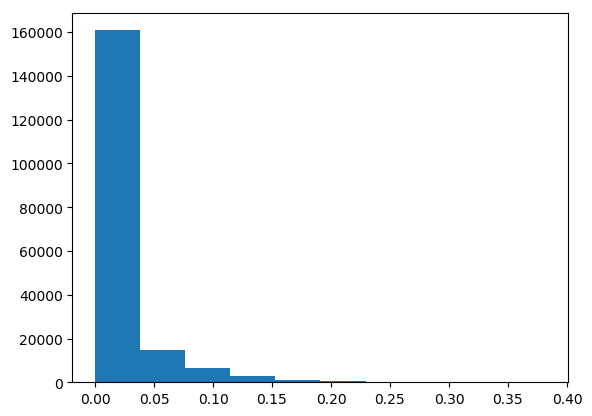

([160844.0, 14660.0, 6651.0, 2871.0, 1046.0, 405.0, 125.0, 40.0, 28.0, 5.0], Float32[0.0, 0.03821791, 0.07643582, 0.11465372, 0.15287164, 0.19108954, 0.22930744, 0.26752535, 0.30574328, 0.34396118, 0.38217908], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f65fb7a8240>, PyObject <matplotlib.patches.Rectangle object at 0x7f65fb7a86a0>, PyObject <matplotlib.patches.Rectangle object at 0x7f65fb7a8588>, PyObject <matplotlib.patches.Rectangle object at 0x7f65fb3dcf60>, PyObject <matplotlib.patches.Rectangle object at 0x7f65fb7cab38>, PyObject <matplotlib.patches.Rectangle object at 0x7f66582c1c88>, PyObject <matplotlib.patches.Rectangle object at 0x7f66582c1a20>, PyObject <matplotlib.patches.Rectangle object at 0x7f65fb7f4c50>, PyObject <matplotlib.patches.Rectangle object at 0x7f65fb7e5e48>, PyObject <matplotlib.patches.Rectangle object at 0x7f65fb275ef0>])

In [153]:
test = vec(r2s[2,:])
replace!(test,NaN => 0)

hist(test)

### Reset fish indices

In [16]:
fish_list = unique(idx_fish)
n_fish = length(fish_list)
reset_idx = collect(1:n_fish)

reset_idx_fish = copy(idx_fish)
for i in 1:length(idx_fish)
    loc = findall(idx_fish[i] .== fish_list)[1]
    reset_idx_fish[i] = Int.(reset_idx[loc])
end

## Z Brain masks

In [17]:
mask_f = matopen(drv*"masks/Zbrain_Masks.mat","r")
masks=read(mask_f,"Zbrain_Masks")
close(mask_f)

In [18]:
regions_f = matopen(drv*"masks/1sISI_regions.mat","r")
keys(regions_f)
per_brain_regions = read(regions_f,"PerBrainRegions")
region_list = vec(read(regions_f,"RegionList"))

12-element Vector{Any}:
 "Thalamus"
 "Cerebellum"
 "Semicircularis"
 "Telencephalon"
 "Tectum"
 "Tegmentum"
 "Habenula"
 "Pretectum"
 "MON"
 "Hindbrain"
 "Raphe_Superior"
 "Interpeduncular_Nucleus"

In [21]:
n_fish = length(unique(idx_fish))
n_frames = size(DF)[2]

1100

## Figure S1A

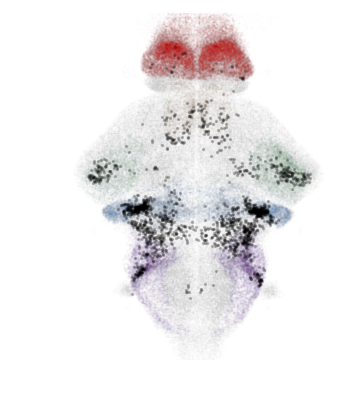

In [102]:
ymn = 300
ymx = 1270
xmn = 0
xmx = 600

fs = 16

a = 0.2
nsa = 0.002
s = 1

sr = sig_rois[1,:][1]


figure(figsize=(3.5,4.5)); 
ax = subplot(111); axis("off")
sub = [9,2,3,1,4]
scatter(centroids[:,2],centroids[:,1],color="lightgray",s=1,alpha=nsa)

ctr = 1
reg_col = [(0.4,0.13,0.62),(0.15,0.42,0.75),(0.19,0.54,0.38),(0.62,0.32,0),(0.72,0,0)]#(0.38,0.62,0.15),
for r in sub
    curr_region = region_list[r]
    idx = Int.(per_brain_regions[curr_region]["idx"])
    scatter(centroids[idx,2],centroids[idx,1],s=s,alpha=0.01,color=reg_col[ctr])    #avg = vec(mean(DF[idx,:],dims=1))
    ctr+=1
end

scatter(centroids[sr,2],centroids[sr,1],color="black",s=2,alpha=a,zorder=3)

ylim(ymn,ymx)
xlim(xmn,xmx)

savefig("figs/FigS1A.png",dpi=600)

## Figure S1B

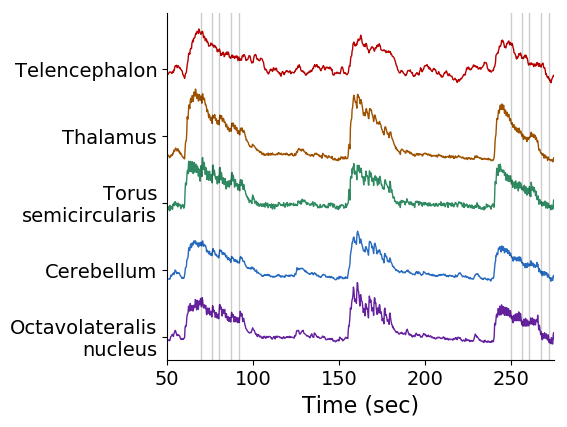

In [105]:
df_avg = []

fs = 16

figure(figsize=(5,4.5))
ax = subplot(111)
x = collect(1:n_frames)./fps
sub = [9,2,3,1,4]
sub_list = ["Octavolateralis\nnucleus","Cerebellum","Torus\nsemicircularis","Thalamus","Telencephalon"]
ctr = 1
for r in sub
    curr_region = region_list[r]
    idx = Int.(per_brain_regions[curr_region]["idx"])
    avg = vec(mean(DF[idx,:],dims=1))
    stdev = vec(std(DF[idx,:],dims=1))./n_fish
    plot(x,(avg.-avg[1]).+ctr*0.05,color=reg_col[ctr],linewidth=1)
    ctr+=1
end

yticks(collect(1:length(sub)).*0.05,sub_list,fontsize=14)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
for ob in oddball_times
    ax.axvline(ob/fps,0,1,color="black",linewidth=1,alpha=0.2)
end
xlim(50,n_frames/fps)
xlabel("Time (sec)",fontsize=fs)

xticks([50,100,150,200,250],[50,100,150,200,250],fontsize=14)
savefig("figs/FigS1B.svg",dpi=600)

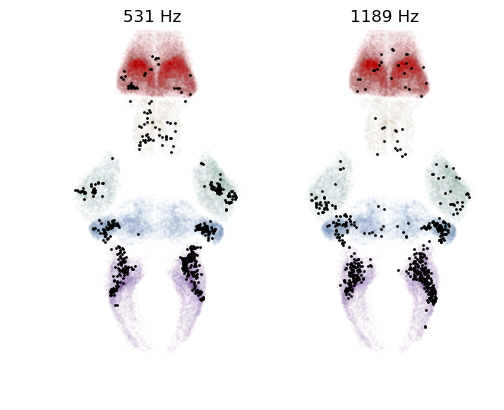

In [101]:
ymn = 300
ymx = 1270
xmn = 0
xmx = 600

fs = 16

a = 0.2
nsa = 0.002
s = 1

sr = sig_rois[1,:][1]


figure(figsize=(5.5,4.5)); 
sub = [9,2,3,1,4]
scatter(centroids[:,2],centroids[:,1],color="lightgray",s=1,alpha=nsa)

reg_col = [(0.4,0.13,0.62),(0.15,0.42,0.75),(0.19,0.54,0.38),(0.62,0.32,0),(0.72,0,0)]#(0.38,0.62,0.15),
sp_ctr = 1
titles = ["531 Hz","1189 Hz"]
for freq in [5,6]
    subplot(1,2,sp_ctr);axis("off"); title(titles[sp_ctr])
    sr = sig_rois[freq,:][1]
    ctr = 1

    for r in sub
        curr_region = region_list[r]
        idx = Int.(per_brain_regions[curr_region]["idx"])
        scatter(centroids[idx,2],centroids[idx,1],s=s,alpha=0.01,color=reg_col[ctr])

        idx = intersect(idx,sr)
        if length(idx) > 0
            scatter(centroids[idx,2],centroids[idx,1],s=s,alpha=1,color="black")
        end
        ctr+=1
    end
    ylim(ymn,ymx)
    xlim(xmn,xmx)
    sp_ctr+=1
end

#savefig("figs/FigS1F.png",dpi=600)